Notes de la séance du 15 Mars - Première séance sur le data challenge

In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv('./data/train_data.csv')

In [3]:
df_train.head()

,Unnamed: 0,RATE,HRSWKD,STATENUM,multiple_full_time_jobs,NAME,MI,JOBCLASS,JC TITLE,RACE,SEX,EMPTYPE,HIREDT,combined_multiple_jobs,ANNUAL
0,67840,0.0,40.0,54316,NaN,HEALTH AND HUMAN SERVICES COMMISSION ...,A,6232,SECURITY OFFICER III ...,BLACK,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,08/01/18,NaN,26331.96
1,76155,0.0,40.0,1286065,NaN,DEPARTMENT OF FAMILY AND PROTECTIVE SERVICES ...,R,5023,CHILD PROTECTIVE SVCS SPEC I ...,WHITE,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,10/12/20,NaN,45799.80
2,86107,0.0,40.0,133785,NaN,TEXAS COMMISSION ON ENVIRONMENTAL QUALITY ...,A,2155,ENGINEER IV ...,HISPANIC,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,10/18/10,NaN,81276.00
3,142906,0.0,40.0,944748,NaN,PARKS AND WILDLIFE DEPARTMENT ...,E,6252,STATE PARK POLICE OFFICER ...,HISPANIC,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,12/14/15,NaN,59232.00
4,59679,0.0,40.0,153878,NaN,HEALTH AND HUMAN SERVICES COMMISSION ...,,5622,TEXAS WORKS ADVISOR II ...,BLACK,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,09/01/04,NaN,39663.96


In [4]:
date = pd.to_datetime(df_train['HIREDT'])
date[date > pd.to_datetime('02/01/21')] -= pd.Timedelta('100Y')

In [5]:
date.min()

Timestamp('1968-12-01 18:00:00')

<AxesSubplot:ylabel='Frequency'>

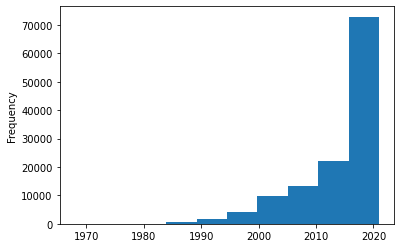

In [7]:
date.dt.year.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

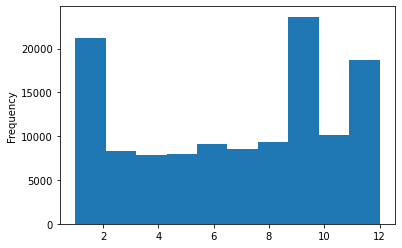

In [24]:
date.dt.month.plot(kind='hist')

In [8]:
pd.to_datetime('02/01/21') - date

0         915 days
1         112 days
2        3759 days
3        1876 days
4        5997 days
            ...   
124722   1219 days
124723   1533 days
124724   3288 days
124725   7644 days
124726    126 days
Name: HIREDT, Length: 124727, dtype: timedelta64[ns]

In [9]:
(pd.to_datetime('02/01/21') - date).dt.days / 365

0          2.506849
1          0.306849
2         10.298630
3          5.139726
4         16.430137
            ...    
124722     3.339726
124723     4.200000
124724     9.008219
124725    20.942466
124726     0.345205
Name: HIREDT, Length: 124727, dtype: float64

In [10]:
((pd.to_datetime('02/01/21') - date).dt.days / 365).max()

52.202739726027396

In [13]:
y_train = df_train['ANNUAL']

In [14]:
X_train = df_train[['RATE', 'HIREDT', 'HRSWKD', 'STATENUM', 'multiple_full_time_jobs', 'combined_multiple_jobs']]

In [15]:
X_train.dtypes

RATE                       float64
HIREDT                      object
HRSWKD                     float64
STATENUM                     int64
multiple_full_time_jobs    float64
combined_multiple_jobs     float64
dtype: object

In [16]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
model = HistGradientBoostingRegressor()
from sklearn import model_selection

In [19]:
REFERENCE_DATE = pd.to_datetime('02/01/21')

def date_to_num(df_col):
    date = pd.to_datetime(df_col.squeeze())
    date[date > REFERENCE_DATE] -= pd.Timedelta('100Y')
    date_delta = REFERENCE_DATE - date
    return (date_delta.dt.days / 365).to_frame()


In [20]:
date_to_num(df_train[['HIREDT']])

,HIREDT
0,2.506849
1,0.306849
2,10.298630
3,5.139726
4,16.430137
...,...
124722,3.339726
124723,4.200000
124724,9.008219
124725,20.942466


In [21]:
from sklearn.preprocessing import FunctionTransformer
date_time_transformer = FunctionTransformer(date_to_num)

In [22]:
date_time_transformer.transform(df_train['HIREDT'])

,HIREDT
0,2.506849
1,0.306849
2,10.298630
3,5.139726
4,16.430137
...,...
124722,3.339726
124723,4.200000
124724,9.008219
124725,20.942466


In [23]:
from sklearn.compose import make_column_transformer

In [25]:
ct = make_column_transformer((date_time_transformer, ['HIREDT']),
                             remainder='passthrough')

In [94]:
ct.fit_transform(X_train)

array([[2.50684932e+00, 0.00000000e+00, 4.00000000e+01, 5.43160000e+04,
                   nan,            nan],
       [3.06849315e-01, 0.00000000e+00, 4.00000000e+01, 1.28606500e+06,
                   nan,            nan],
       [1.02986301e+01, 0.00000000e+00, 4.00000000e+01, 1.33785000e+05,
                   nan,            nan],
       ...,
       [9.00821918e+00, 0.00000000e+00, 4.00000000e+01, 1.69680000e+04,
                   nan,            nan],
       [2.09424658e+01, 0.00000000e+00, 4.00000000e+01, 7.40000000e+03,
                   nan,            nan],
       [3.45205479e-01, 0.00000000e+00, 4.00000000e+01, 1.28196800e+06,
                   nan,            nan]])

In [27]:
model = HistGradientBoostingRegressor()
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(ct, model)

In [28]:
model_selection.cross_val_score(pipe, X_train, y_train)

array([0.16312779, 0.16222883, 0.15375193, 0.15991574, 0.14577252])